# 3-Recommendation Systems-İş Öneri Sistemi

<img src="job.png">

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import missingno as msng

pd.set_option('display.max_columns',185)
pd.set_option('display.max_rows',185)

from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import string

## Veri İnceleme ve Temizleme:

In [2]:
df=pd.read_csv("jobs.csv")

In [7]:
df.head()

,Unnamed: 0,Job Salary,Job Experience Required,Key Skills,Role Category,Functional Area,Industry,Job Title
0,0,Not Disclosed by Recruiter,5 - 10 yrs,Media Planning| Digital Media,Advertising,"Marketing , Advertising , MR , PR , Media Plan...","Advertising, PR, MR, Event Management",Media Planning Executive/Manager
1,1,Not Disclosed by Recruiter,2 - 5 yrs,pre sales| closing| software knowledge| clien...,Retail Sales,"Sales , Retail , Business Development","IT-Software, Software Services",Sales Executive/Officer
2,2,Not Disclosed by Recruiter,0 - 1 yrs,Computer science| Fabrication| Quality check|...,R&D,"Engineering Design , R&D","Recruitment, Staffing",R&D Executive
3,3,"2,00,000 - 4,00,000 PA.",0 - 5 yrs,Technical Support,Admin/Maintenance/Security/Datawarehousing,"IT Software - Application Programming , Mainte...","IT-Software, Software Services",Technical Support Engineer
4,4,Not Disclosed by Recruiter,2 - 5 yrs,manual testing| test engineering| test cases|...,Programming & Design,IT Software - QA & Testing,"IT-Software, Software Services",Testing Engineer


1. "Unnamed: 0" -> "İş Kimliği"
2. "Job Salary" -> "İş Maaşı"
3. "Job Experience Required" -> "İş Tecrübesi Gereksinimi"
4. "Key Skills" -> "Anahtar Beceriler"
5. "Role Category" -> "Rol Kategorisi"
6. "Functional Area" -> "İşlevsel Alan"
7. "Industry" -> "Endüstri"
8. "Job Title" -> "İş Başlığı"

In [9]:
# Sütun adlarını güncelle
df.rename(columns={"Unnamed: 0": "Job_ID"}, inplace=True)

In [15]:
df.columns

Index(['Job_ID', 'Job Salary', 'Job Experience Required', 'Key Skills',
       'Role Category', 'Functional Area', 'Industry', 'Job Title', 'Skills'],
      dtype='object')

In [11]:
df.shape

(27010, 8)

In [14]:
df.sample(3)

,Job_ID,Job Salary,Job Experience Required,Key Skills,Role Category,Functional Area,Industry,Job Title,Skills
19813,21996,Openings: 1,2 - 5 Years,spring|java|j2ee|hibernate,Programming & Design,"IT Software - Application Programming , Mainte...",IT-Software / Software Services,Software Developer,"[spring, java, j2ee, hibernate]"
26200,29097,Not Disclosed by Recruiter,9 - 14 yrs,CVS| Core Java| Rest| JBoss| Weblogic| XSD| J2...,Programming & Design,"IT Software - Application Programming , Mainte...","IT-Software, Software Services",Software Developer,"[CVS, Core Java, Rest, JBoss, Weblogic, X..."
5212,5793,Not Disclosed by Recruiter,4 - 8 Years,python|software development|system programming...,Programming & Design,IT Software - System Programming,IT-Software / Software Services,Software Developer,"[python, software development, system programm..."


In [13]:
# "Key Skills" sütunundaki becerileri ayırma
df['Skills'] = df['Key Skills'].str.split('|')

In [17]:
# Veri çerçevesinden istenmeyen sütunları kaldırma
df = df.drop(["Key Skills", "Functional Area", "Industry"] , axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27010 entries, 0 to 27009
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Job_ID                   27010 non-null  int64 
 1   Job Salary               27010 non-null  object
 2   Job Experience Required  27010 non-null  object
 3   Role Category            27010 non-null  object
 4   Job Title                27010 non-null  object
 5   Skills                   27010 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.2+ MB


In [20]:
df.isnull().sum().sort_values(ascending=False)

Job_ID                     0
Job Salary                 0
Job Experience Required    0
Role Category              0
Job Title                  0
Skills                     0
dtype: int64

## Veri Görselleştirme:

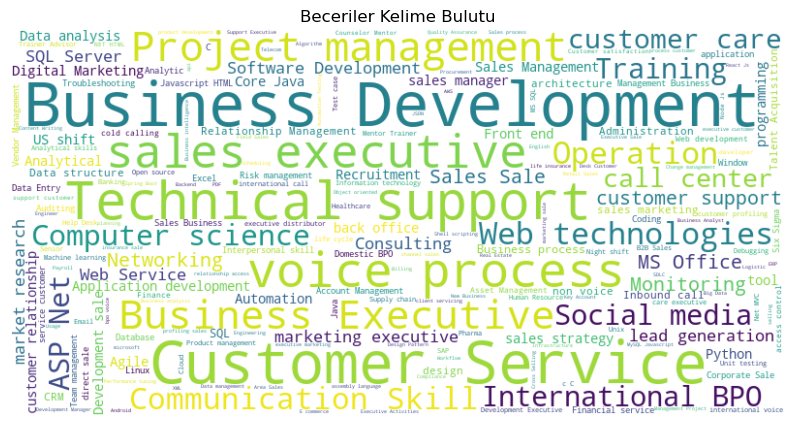

In [25]:
# "Skills" sütunu için kelime bulutu
from wordcloud import WordCloud
skills_text = ' '.join(df['Skills'].apply(lambda x: ' '.join(x)))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Beceriler Kelime Bulutu')
plt.axis('off')
plt.show()

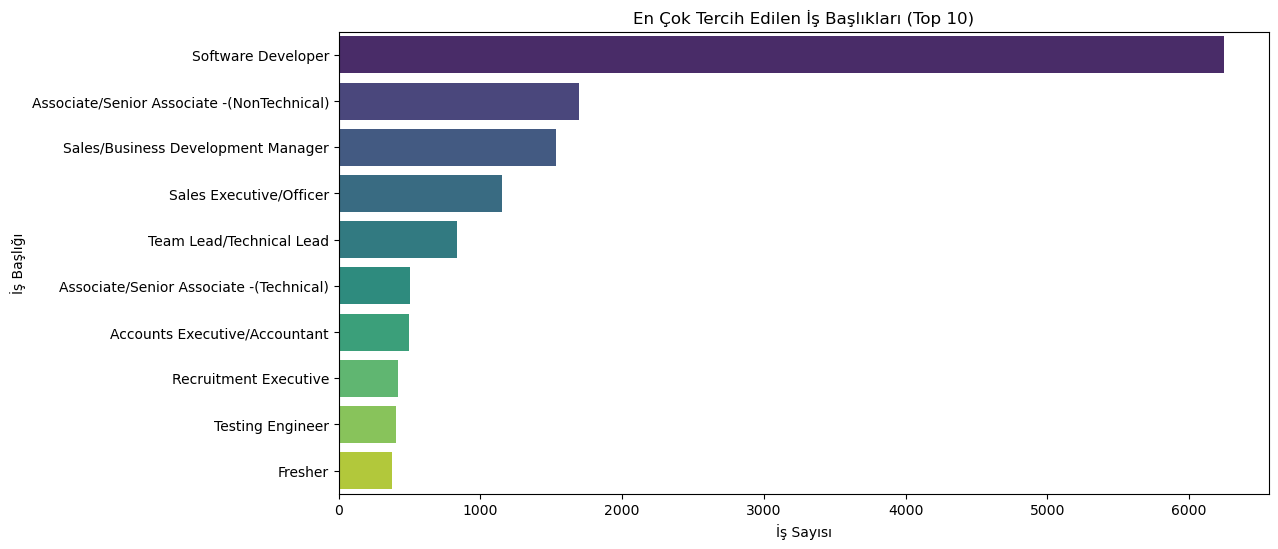

In [26]:
# En çok tercih edilen ilk 10 iş başlığını seçme
top_10_jobs = df['Job Title'].value_counts().head(10)

# Grafiği çizme
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_jobs.values, y=top_10_jobs.index, palette='viridis')
plt.title('En Çok Tercih Edilen İş Başlıkları (Top 10)')
plt.xlabel('İş Sayısı')
plt.ylabel('İş Başlığı')
plt.show()

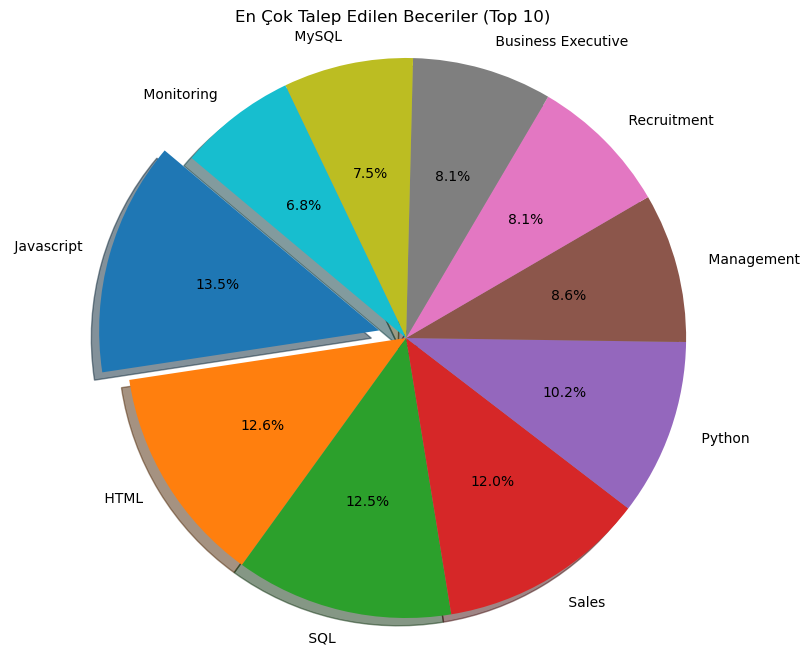

In [29]:
import matplotlib.pyplot as plt
from collections import Counter

# Tüm becerileri bir liste olarak birleştirme
all_skills = [skill for skills_list in df['Skills'] for skill in skills_list]

# Beceirlerin sayısını sayma
skill_counts = Counter(all_skills)

# En çok talep edilen ilk 10 beceriyi seçme
top_10_skills = dict(skill_counts.most_common(10))

# Verileri hazırlama
labels = top_10_skills.keys()
sizes = top_10_skills.values()
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # Dilimlerden sadece ilk dilimi vurgulama (0.1 olarak ayarlanmış)

# Dilimli pasta grafiği oluşturma
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('En Çok Talep Edilen Beceriler (Top 10)')
plt.axis('equal')  # Daireyi daire olarak görüntüleme
plt.show()

## Modelleme:

"Job_ID", "Job Salary", "Job Experience Required", "Role Category", "Job Title" ve "Skills" sütunları arasından hangilerini kullanmanız gerektiği, recommendation system (öneri sistemi) başarınızı etkileyebilir. İşte her bir sütunun kullanılabilirliğini ve nasıl bir etki yaratabileceğini göz önünde bulundurarak bir değerlendirme:

1. **Job_ID**: Bu sütun iş ilanlarını benzersiz bir şekilde tanımlar, ancak öneri sistemi için kullanılması gerekmeyebilir. Çünkü kullanıcıların iş ilanlarına göre önerilmesi, genellikle işin özelliklerine ve kullanıcıların beceri ve deneyimlerine dayanır. Bu sütunu modelde kullanmak, spesifik iş ilanlarını önermek yerine iş ilanları arasındaki benzersizliği vurgular.

2. **Job Salary**: Bu sütun iş maaşlarını temsil eder. Kullanıcıların maaş beklentileri ve iş ilanlarının maaş aralıkları dikkate alındığında, bu sütun iş ilanı ve kullanıcı profilini eşleştirmede kullanışlı olabilir. Ancak, iş öneri sistemlerinin temelinde bu sütun genellikle daha az önemlidir.

3. **Job Experience Required**: İş deneyimi gereksinimleri, kullanıcıların iş ilanlarına uygunluğunu değerlendirmede önemli bir faktördür. Bu sütun, kullanıcıların deneyim seviyelerini ve ilanların gereksinimlerini karşılaştırarak önerileri kişiselleştirmede kullanılabilir.

4. **Role Category**: İş kategorileri, kullanıcıların ilgi alanları ve tercihlerini anlamada yardımcı olabilir. Örneğin, bir kullanıcı "Programlama ve Tasarım" kategorisindeki iş ilanlarına daha fazla ilgi gösterebilir. Bu sütun, iş ilanlarını gruplandırmak ve kullanıcıların tercihlerine uygun işleri önermek için kullanılabilir.

5. **Job Title**: İş başlıkları, kullanıcıların ilgi alanlarını ve kariyer hedeflerini yansıtabilir. Bu sütun, iş ilanları arasında benzerlikleri bulmak ve kullanıcılara uygun iş ilanlarını önermek için kullanılabilir.

6. **Skills**: Beceriler, kullanıcıların yeteneklerini ve iş ilanlarının gereksinimlerini daha iyi eşleştirmek için önemlidir. İş ilanlarının ve kullanıcı profilinin içerdiği becerileri karşılaştırarak öneriler kişiselleştirilebilir.

Başarılı bir recommendation system tasarlarken, verilerinizi ve kullanıcı tercihlerini daha iyi anlamak için bu sütunları kullanabilirsiniz. Özellikle deneyim gereksinimleri ve beceriler, kullanıcıların iş ilanlarına uygunluğunu değerlendirmede önemli role sahiptir. Ancak, her bir sütunu ne kadar etkili bir şekilde kullanacağınızı belirlemek için veri analizi ve modelleme süreçlerini tamamlamanız gerekecektir.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# TfidfVectorizer ile metin verilerini işleme
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Skills'].apply(lambda x: ' '.join(x)))

# Benzerlik matrisini hesapla
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# İş önerileri yapmak için bir fonksiyon tanımla
def get_job_recommendations(job_title, cosine_sim=cosine_sim):
    idx = df.index[df['Job Title'] == job_title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    job_indices = [i[0] for i in sim_scores]
    return df['Job Title'].iloc[job_indices]

# Örnek iş önerisi
recommended_jobs = get_job_recommendations("Testing Engineer")
print(recommended_jobs)

7421             Testing Engineer
10470            Testing Engineer
2527             Testing Engineer
4696             Testing Engineer
14346                     Fresher
919              Testing Engineer
594              Testing Engineer
23264            Testing Engineer
5514             Testing Engineer
17386    Team Lead/Technical Lead
Name: Job Title, dtype: object


Bu kod örneği, bir öneri sistemi oluşturmak için kullanılan Python kodunu temsil ediyor. Bu kod, becerileri kullanarak iş ilanları arasındaki benzerlikleri hesaplamak ve belirli bir iş ilanı için benzer iş ilanlarını önermek için kullanılıyor.

Aşağıda kodun adım adım açıklaması:

1. `TfidfVectorizer` kullanılarak metin verilerini işleme:
   Bu adımda, "Skills" sütunundaki becerileri birleştirerek bir metin vektörü oluşturuyoruz ve bu metin verilerini TF-IDF (Term Frequency-Inverse Document Frequency) vektörlerine dönüştürüyoruz. Bu, metin verilerini sayısal bir forma dönüştürmemize yardımcı olur.

2. Benzerlik matrisini hesaplama:
   TF-IDF vektörlerini kullanarak, iş ilanları arasındaki benzerlikleri hesaplamak için bir benzerlik matrisi oluşturuyoruz. Bu matris, her iş ilanının diğer iş ilanlarına göre benzerliğini içerir.

3. `get_job_recommendations` fonksiyonunu tanımlama:
   Bu fonksiyon, bir iş ilanının adını ve benzerlik matrisini alır. İlgili iş ilanının benzer iş ilanlarını bulmak için bu fonksiyonu kullanabilirsiniz.

4. Öneri yapma:
   `get_job_recommendations` fonksiyonu, belirli bir iş ilanının benzer iş ilanlarını bulur ve bunları benzerlik sırasına göre sıralar. Bu şekilde, belirli bir iş ilanı için önerilen iş ilanlarını elde edebilirsiniz.

Kodun örneğinde, "Testing Engineer" adlı bir iş ilanı için benzer iş ilanlarını öneren bir örnek bulunuyor. Kodu farklı iş ilanları için de kullanabilirsiniz, sadece `get_job_recommendations` fonksiyonuna farklı bir iş ilanı adı vererek kullanabilirsiniz. Bu şekilde, veri setinizdeki farklı iş ilanları için öneriler alabilirsiniz.

In [ ]:
# KNN

K-Nearest Neighbors (KNN) modeli kullanarak iş önerileri oluşturmak için önce veriyi hazırlamamız ve ardından bir KNN modeli eğitmemiz gerekecek. İşte KNN modeli ile bu işlemi adım adım gerçekleştirmenize yardımcı olacak bir kod örneği:

In [37]:
# TF-IDF vektörlerini oluşturmak için TfidfVectorizer kullanma
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Skills'].apply(lambda x: ' '.join(x)))

# Kullanıcı profilini oluşturun (örneğin, deneyim gereksinimleri ve beceriler)
user_profile = pd.DataFrame({'Skills': ['Digital Media Media Planning']})

# Kullanıcı profilini modele uygulayın
user_profile_vector = tfidf_vectorizer.transform(user_profile['Skills'])
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(tfidf_matrix)

# Kullanıcı profilini modele uygulayın
user_profile_vector = tfidf_vectorizer.transform(user_profile['Skills'])
_, indices = knn_model.kneighbors(user_profile_vector)

# Önerilen iş ilanlarını gösterin
recommended_jobs = df.iloc[indices[0]]['Job Title']
print(recommended_jobs)

0                  Media Planning Executive/Manager
20730                     Clinical Research Manager
23610    Public Relations & Media Relations Manager
10597                             Content Developer
1901                              Marketing Manager
Name: Job Title, dtype: object


In [38]:
# Kullanıcıdan bir iş adı girmesini isteyin
user_job = input("Bir iş adı girin: ")

# Kullanıcı profilini oluşturun (örneğin, deneyim gereksinimleri ve beceriler)
user_profile = pd.DataFrame({'Skills': [user_job]})

# Kullanıcı profilini modele uygulayın
user_profile_vector = tfidf_vectorizer.transform(user_profile['Skills'])
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(tfidf_matrix)

# Kullanıcı profilini modele uygulayın
user_profile_vector = tfidf_vectorizer.transform(user_profile['Skills'])
_, indices = knn_model.kneighbors(user_profile_vector)

# Önerilen iş ilanlarını gösterin
recommended_jobs = df.iloc[indices[0]]['Job Title']
print("Önerilen İş İlanları:")
print(recommended_jobs)

Bir iş adı girin: Clinical Research Manager
Önerilen İş İlanları:
26151    Clinical Research Associate/Scientist
1971     Clinical Research Associate/Scientist
932                        Clinical Researcher
23428    Clinical Research Associate/Scientist
22685    Clinical Research Associate/Scientist
Name: Job Title, dtype: object


## Sonuç: 

Bu proje, iş deneyimi, maaş beklentileri ve beceri seti gibi kullanıcı profili bilgilerini kullanarak, veri bilimi yöntemlerini kullanarak iş arayanlara özel iş önerileri sunan bir iş öneri sistemi oluşturmayı amaçlıyor. Kullanıcıların girdiği bilgilere göre, benzer iş ilanlarını önererek iş arama sürecini daha etkili hale getirmeyi hedefliyor.

### ***********************************************************************************************************************

In [ ]:
## Ayrıca yapılabilir,

In [40]:
df.columns

Index(['Job_ID', 'Job Salary', 'Job Experience Required', 'Role Category',
       'Job Title', 'Skills'],
      dtype='object')

In [45]:
from scipy.sparse import hstack

In [60]:
# Kullanıcıdan iş deneyimi, maaş ve beceri bilgilerini alın
user_experience = float(input("İş deneyiminizi yıl cinsinden girin: "))
user_salary = float(input("Aylık maaş aralığınızı girin (örn. 5000): "))
user_skills = input("Beceri listesi girin (virgülle ayrılmış): ").split(',')

# Kullanıcı profilini oluşturun
user_profile = pd.DataFrame({
    'Job Experience Required': [user_experience],
    'Job Salary': [user_salary]
})

# TF-IDF vektörlerini oluşturmak için TfidfVectorizer kullanma
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Skills'].apply(lambda x: ' '.join(x)))

# Kullanıcı profilini iş ilanlarını iş deneyimi ve maaş ile birleştirerek oluşturun
user_profile_data = pd.concat([user_profile] * df.shape[0], ignore_index=True)

# KNN modelini oluşturun ve eğitin
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(hstack([user_profile_data, tfidf_matrix]))

# Önerilen iş ilanlarını gösterin
_, indices = knn_model.kneighbors(user_profile_data)
recommended_jobs = df.iloc[indices[0]]['Job Title']
print("Önerilen İş İlanları:")
print(recommended_jobs)

İş deneyiminizi yıl cinsinden girin: 3
Aylık maaş aralığınızı girin (örn. 5000): 9000
Beceri listesi girin (virgülle ayrılmış): Python


ValueError: X has 2 features, but NearestNeighbors is expecting 6463 features as input.

In [51]:
# İş Deneyimi için
import re

def extract_experience(text):
    # "5 - 10 yrs" gibi bir metni işle
    match = re.search(r'(\d+)\s*-\s*(\d+)\s*yrs', text)
    if match:
        start_experience = int(match.group(1))
        end_experience = int(match.group(2))
        # Ortalama iş deneyimi değerini döndür
        return (start_experience + end_experience) / 2
    else:
        # Eğer uygun formatta bir metin değilse 0 olarak kabul et
        return 0

# "Job Experience Required" sütununu düzenle
df['Job Experience Required'] = df['Job Experience Required'].apply(extract_experience)

In [55]:
# Maaş için
import re

# "Not Disclosed by Recruiter" olan satırları 0 ile doldurun
df['Job Salary'] = df['Job Salary'].replace('Not Disclosed by Recruiter', 0)

# "Job Salary" sütununu işleme alın
def extract_salary(text):
    # "2,00,000 - 4,00,000 PA." gibi bir metni işle
    match = re.search(r'([\d,]+)\s*-\s*([\d,]+)\s*PA', str(text))
    if match:
        start_salary = float(match.group(1).replace(',', ''))
        end_salary = float(match.group(2).replace(',', ''))
        return (start_salary + end_salary) / 2
    else:
        return None

# Maaş aralıklarını sayısal değerlere çevirin
df['Job Salary'] = df['Job Salary'].apply(extract_salary)

# Artık "Job Salary" sütunu kullanarak öneri yapabilirsiniz
print(df[['Job Title', 'Job Salary']])

                                        Job Title  Job Salary
0                Media Planning Executive/Manager         NaN
1                         Sales Executive/Officer         NaN
2                                   R&D Executive         NaN
3                      Technical Support Engineer    300000.0
4                                Testing Engineer         NaN
...                                           ...         ...
27005                          Software Developer         NaN
27006                          Operations Manager         NaN
27007                          Lecturer/Professor         NaN
27008                          Software Developer         NaN
27009  Search Engine Optimisation /SEO Specialist         NaN

[27010 rows x 2 columns]
